

* For this one it seems it wants me to fill out some of the sections with my own code.
So basically I'll be following along.

* Problem Scoping
The overall goal is to create a recommendation model for users and their books;
for doing so is to increase retention and by virtue create stable, recurring income.
This would imply that the 'problem' to solve would be within the customers for they are spending more time searching rather then engaging.
This model then has within it the hope that this manual searching process can totally or almost eliminate that segment of the user experience: the question is how good can I make it.
** Data & the model to be used.
In this case, data is given;
but if it weren't, then I would be looking towards sources like Kaggle or within the organization for it.
The model though is without, so naturally looking into Surprise (a package I'll be using later) for some model inspo, I find that most of these algorithms for recommendation are clustering-like, so SVM or KNN.
* Importing, loading, and exploring.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

df_b = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Books.csv")
df_r = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Ratings.csv")
df_u = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Users.csv")

print(df_b.head(5))
print(df_r.head(5))
print(df_u.head(5))

/tmp/ipykernel_46048/203446975.py:8: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/


Much is what I would expect out of such datasets, but I do notice that all three share the ISBN number for such books to be recommended to others.
** As within the guiding notebook, it's a good idea to get a better idea of the kind of users I'm working with.
Such an attribute of a user which I have at hand to tell me more about them is their age, as that tends to get us around where interest might lay.
To see this visually I can display the age range as a distribution.

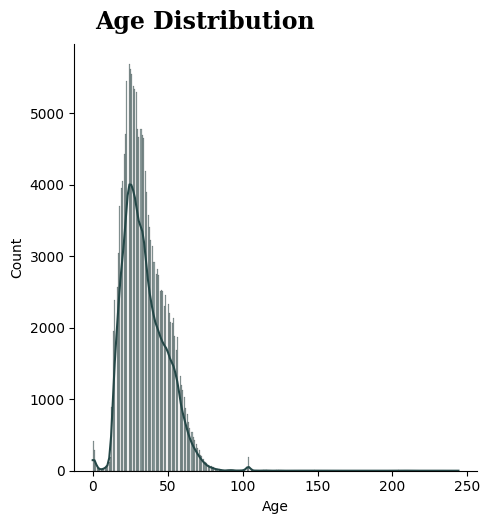

In [12]:
df_u = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Users.csv")

def plot_distribution(feature, data):
    sns.displot(x=feature, data=data, kde=True, color='#244747');
    plt.figtext(0.2, 1, '%s Distribution'%feature, fontfamily='serif', fontsize=17, fontweight='bold');

plot_distribution('Age', df_u)



Looking at the template from the notebook, I can see that there is the feature to be graphed from its source of data which is then repeated in the sns.displot.
This should mean the the feature--> age which is from the data-->df_u in this case.
I only pass this to the plot_distribution function call as this acts as a wrapper for seaborn and thus passes such arguments to its function call as well.
Looking over the distribution, I find that the mass of the users age range is from twenty to forty years of age with strangely a long tail towards ages reaching that beyond humans can live, so this is something to clean later (via dropping);
generally too, there are some missing values for the ages, which I'm unsure as yet if I'd like to drop though as well when such user's rows provide other data as well then just age.
With that in mind, what sort of books are on our platform by age as well?
Such an insight could help to understand what age demographic might like which due to its publication year (most of us do have books we remember we'd like to read from years ago).


* Recommendation Models
** Demographic Filtering recommendation model.
First, what is such a filtering style? As its name might give off, this is filtering of content based off a user's demographics, so things like age which I've shown, gender, and so on.
It can seem like this is supposed to be THE recommendation model, but this isn't the case;
rather this is to collect statistics within the data for the creation of another recommendation model which will be Collaborative based: I'll talk more about that later.

In [14]:
data = df_r.groupby('ISBN').agg(['mean', 'count'])['Book-Rating'].reset_index()

# generating a score based off the mean rating and total number of times the book is rated
m = data['count'].quantile(0.99)
data = data[data['count']>m]
print('m =', m)
print(data.shape)

R = data['mean'] # average for the book, so (mean) = (rating)
V = data['count'] # number of votes for the book = (votes)
C = data['mean'].mean() # mean vote across all books

# Corrected calculation syntax
data['weighted rating'] = (V/(V+m))*R + (m/(V+m))*C
data = data.sort_values('weighted rating', ascending=False).reset_index(drop=True)

# Corrected merge to use df_b (books) instead of df_u (users) to get titles
data = pd.merge(data, df_b, on='ISBN')[['Book-Title', 'Book-Author', 'mean', 'count', 'weighted rating', 'Year-Of-Publication']].drop_duplicates('Book-Title').iloc[:20]

data

m = 36.0
(3306, 3)


,Book-Title,Book-Author,mean,count,weighted rating,Year-Of-Publication
0,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,6.541237,194,5.985285,2000
1,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,6.611765,170,5.978717,1999
2,Free,Paul Vincent,7.962963,54,5.973507,2003
3,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,6.467005,197,5.929681,1999
4,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,6.363095,168,5.767724,1998
5,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,5.571856,334,5.320583,2003
6,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,6.206349,63,5.036522,1999
7,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,6.041667,72,5.024219,1991
9,Falling Up,Shel Silverstein,6.921053,38,5.008320,1996
10,The Stand (The Complete and Uncut Edition),Stephen King,6.175439,57,4.942104,1990



So what had I done here?
In the beginning it was assigning the object 'data' to the rating dataframe where the dataframe's column of ISBN IDs of books is aggregated by the mean and count of book ratings, where the index is reset.
After this the count column belonging now to the 'data' object is passed to the quantile function which is specified to 0.99, meaning such a minimum vote is required to be within the top 250 of books.
The Data object is then re-assigned as any point having a counter greater then the specified quantile, where such a value for a point is printed to be equal to that quantile value and then it's the shape of object Data is printed.
After this, the mean, count, and mean vote of the data object is assigned to their respective variables, where such variables/values are used to calculate the weighted rating for the books;
and thereafter the index of the object is reset along with a sorted value function passed the weight ratings.
After this the data object is merged with itself, the user database, with it 'on' the ISBN IDs of the books, with it further creating columns for the titles, count, etc and dropping duplicates of book titles.
Before going into what's given after all of this (which can be seen to be just some value) it's better to further understand what's really going on here.
The final result created as written is a merging of recently re-declared object 'data' which is now a weighted value list of book ratings based off several statistics (mean for book votes, number of voters for a book, and mean vote across all the books);
this is to say further that such a object now is such a list along with the columns of Book title, year of publication, and so on.
What this seems to have created then is a dataframe containing such books & their statistics with that of user profiles and their own votes contributing to the weighted list.
*** With twenty highest rated books gotten & into a dataframe, I know have to do the same but for authors.
The process for this is somewhat similar for how I gotten the top highest rated books.

Columns: ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


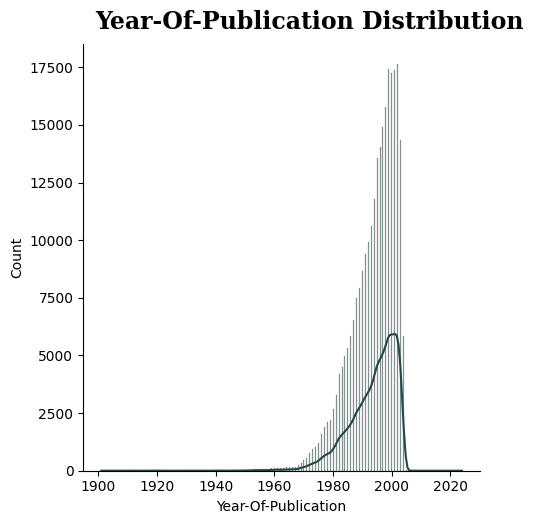

In [30]:
df_b = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Books.csv", 
                   sep=';', 
                   encoding='latin-1', 
                   engine='python',
                   on_bad_lines='skip',
                   quoting=1,
                   escapechar='\\')  # Add escape character handling

# Check if columns were parsed correctly
if len(df_b.columns) == 1:
    # If not, try with comma separator instead
    df_b = pd.read_csv("/home/nate/NextCloud/Roam/Classes/Intro_to_ML/assignmnets/week_14/Books.csv", 
                       sep=',', 
                       encoding='latin-1', 
                       engine='python',
                       on_bad_lines='skip')

print("Columns:", df_b.columns.tolist())

df_b['Year-Of-Publication'] = pd.to_numeric(df_b['Year-Of-Publication'], errors='coerce')
df_b.dropna(subset=['Year-Of-Publication'], inplace=True)
current_year = pd.Timestamp('now').year
df_b = df_b[
    (df_b['Year-Of-Publication'] > 1900) & 
    (df_b['Year-Of-Publication'] <= current_year)
]

def plot_distribution(feature, data):
    sns.displot(x=feature, data=data, kde=True, color='#244747')
    plt.figtext(0.2, 1, f'{feature} Distribution', fontfamily='serif', fontsize=17, fontweight='bold')

plot_distribution('Year-Of-Publication', df_b)


- I'm having some trouble understanding how to 'get book-author and title from df3'.
Looking into it, I find there a a couple of different ways of doing it depending on the type of thing which you wish to grab.
I just want two columns, so this would be the use of single brackets adjacent to the dataframe;
this is a subset of the dataframe, so it would have to be a new object.
- Not sure if I need to do anything regarding the index of the dataframes, so I've left them out for now.
With weighted rating of the authors (from the subset of the df_b frame ) I have to create a user book rating matrix;
this would mean creating a matrix array containing the user book ratings points/values.
After this I would be then getting a similar matrix but with the user-ids for those who have read more then fifty books, which means I'm believing in some sort of ethos of their votes or maybe I know who to overlook when targeting different sorts of users.

In [31]:
# Option 1: Filter to most active users and most rated books first
# This dramatically reduces memory usage

# Keep only users with at least 200 ratings (adjust threshold as needed)
user_counts = df_r['User-ID'].value_counts()
active_users = user_counts[user_counts >= 200].index

# Keep only books with at least 50 ratings (adjust threshold as needed)
book_counts = df_r['ISBN'].value_counts()
popular_books = book_counts[book_counts >= 50].index

# Filter the dataframe
df_r_filtered = df_r[
    df_r['User-ID'].isin(active_users) & 
    df_r['ISBN'].isin(popular_books)
]

print(f"Original shape: {len(df_r)} ratings")
print(f"Filtered shape: {len(df_r_filtered)} ratings")
print(f"Users: {df_r_filtered['User-ID'].nunique()}")
print(f"Books: {df_r_filtered['ISBN'].nunique()}")

# Now create the pivot table with filtered data
df_u_matrix = df_r_filtered.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0  # Fill NaNs with 0 during pivot
)

# Convert to numpy array (no need for sparse matrix)
df_u_MV = df_u_matrix.values

print(f"Matrix shape: {df_u_MV.shape}")
print(f"Memory usage: {df_u_MV.nbytes / (1024**3):.2f} GB")

Original shape: 1149780 ratings
Filtered shape: 92050 ratings
Users: 897
Books: 2185
Matrix shape: (897, 2185)
Memory usage: 0.01 GB



I chose to use scipy to create a sparse version of the matrix for computational speed (and why not).
** Collaborative Filtering.
Collaborative filtering is a recommendation model which uses users data (their dislikes, interest, etc) to recommend things to other users with similar taste.

In [33]:
# creating merged dataframe and dropping any empty movies.
df1 = df_r
df3 = df_b

# Standard merge logic for Recommenders: Merge Ratings and Books
df1_df3 = pd.merge(df1, df3, on='ISBN')
df1_df3 = df1_df3.dropna() 

# getting the count of repeating books within the above dataframe, turning it into its own.
counts = df1_df3['Book-Title'].value_counts() 
counts_df = counts.reset_index()
counts_df.columns = ['Book-Title', 'count']
df1_df3 = df1_df3.merge(counts_df, on='Book-Title', how='left') 

isbn = df1_df3.drop_duplicates('ISBN').sort_values('count', ascending=False).iloc[:100]['ISBN']

# Another filter process but this time for ISBN IDs
df1_df3 = df1_df3[df1_df3['ISBN'].isin(isbn)].reset_index(drop=True)

# Filter ratings data to only include these top 100 ISBNs to avoid memory issues
df_r_filtered = df_r[df_r['ISBN'].isin(isbn)]

# Also filter to users who have rated at least 50 books from our filtered set
user_rating_counts = df_r_filtered['User-ID'].value_counts()
active_users = user_rating_counts[user_rating_counts >= 50].index
df_r_filtered = df_r_filtered[df_r_filtered['User-ID'].isin(active_users)]

print(f"Filtered to {len(df_r_filtered)} ratings")
print(f"Users: {df_r_filtered['User-ID'].nunique()}")
print(f"Books: {df_r_filtered['ISBN'].nunique()}")

# creating the user rating matrix with filtered data
df_u_matrix = df_r_filtered.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0
)

df_u_MV = df_u_matrix.values
spare_df_u_MV = csr_matrix(df_u_MV)

print(f"Matrix shape: {df_u_MV.shape}")
print(f"Sparse matrix created successfully")

sparse_df_u_filtered = spare_df_u_MV

Filtered to 53 ratings
Users: 1
Books: 53
Matrix shape: (1, 53)
Sparse matrix created successfully




- Type of df5 for df3 which is wanting to 
get book titles not 
movie titles. 
- Want to use df1 to get users id, isbn, and book rating with its merging of df3 to connect it to ratings: so df_b and df_u
- Looking into the sort of 'merging' process I should use in Pandas, I find that the one I'd want here is, well, Merging.
Ultimately the two dataset together share a kind of logical relation to each other by df1 having the users with their ratings and df3 has the book titles for such ratings.
Such a combining method will connect any features that share a common key: actually, it's the case that there the ordering of such common terms might not be needed, but what is needed are some matching columns to combine into one;
such a process is pandas' concat() method. 
- I'm not sure why there is a want to get the total amount of occurrences per book.
Looking at the two dataframes, it would seem this would be to spot any repeating entries of the same book that could boost its recommendation;
further in the notebook nothing is dropped so I could expect not to see any repeating titles.
I've found I can do such a process using pandas, specifically with juxtaposing the column with its dataframe where the method "value_counts()" is passed such a column to get another dataframe which has as its index the book titles with its corresponding value for its count within the prior dataframe.
- Getting the top 100 books by virtue of their count seems to imply there is a 'count' column within the merged dataset I've created, but that doesn't match the solo creation of the dataframe counts.
So something seems to gone amiss here. It could be that the 'counts' dataframe should be merged with df1_df3, or possibly the 'counts' dataframe is in some sense consulted when sorting the books by ISBN where any duplicates are dropped based off this filter process.
How this is supposed to look and process is dependent on what's desired.
From what the is written for the 'isbn' dataframe declaration it seems there should exist a 'count' column which is sorted.
So to put it together, it seems I to have a dataframe called 'isbn' which includes the ISBN of books and their counts of occurrences;
so perhaps it would just be the creation of such a dataframe 'isbn' which would then be merged into df1_df3 (I think..)

  So how I fixed this was to create a series of the counts of book titles in the original merged dataframe where such a series is the converted into its own dataframe and added the columns or Book Title and count.
After this I had merged to the left of Book Titles in the originally merged dataset in it, which means the dataframe df1_df3 (the original) has such a column now.
- In wanting to get the use IDs for those who have read more then fifty books, I have to wonder how such a thing would be done.
Users are likely to have rated more then a single book which would show up in the ratings columns, but this would also imply that some books by the ISBN would have more ratings then others form the same group of users (really clustering could be used here).
This would mean I would have to filter the created matrix (and possibly turn it into a dataframe) for users which has fifty or more provided entries in the Book-Ratings column.
Generally there is some confusion on how this is all supposed to work due to me not fully understanding how such things are connected together, like that of users & their ratings to such books.
I've found that I don't have to convert the sparse matrix to a dataframe in order to do this, but this does then require me to first find the amount of ratings, create a boolean mask where the count is 50 or more, and then use that mask to find the relevant users (rows) form the matrix.
- The ISBN filtering object assignment is another process which isn't very clear.
It seems it's filtering the merged dataset by values being with the rows belonging to the ISBN column which means the dataframe will decrease due to dropping any empty rows in such a column.
** Using the Surprise Library
Such a library is often used to build recommendation models when dealing with explicit rating data like that is had in df1/df_u.

In [37]:

import numpy as np
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate

reader = Reader(rating_scale=(0, 10))

# Load data - ensure no NaN values in these columns
df_r_clean = df_r[['User-ID', 'ISBN', 'Book-Rating']].dropna()

surprise_data = Dataset.load_from_df(df_r_clean, reader)
trainset, testset = train_test_split(surprise_data, test_size=0.25)

benchmark = []
for algorithm in [SVD()]:
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(tmp)

benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
print(benchmark_df)

# Train the model
svd = SVD()
svd.fit(trainset)

# Select a user
index_val = 2131
if index_val >= len(df_r_clean):
    index_val = 0  # Fallback if index is out of range

userId = df_r_clean.iloc[index_val]['User-ID'] 

books = []
ratings = []
titles = []

# Get books the user has already rated
user_books = df_r_clean[df_r_clean['User-ID'] == userId]['ISBN'].tolist()

# Get all unique books (limiting to reasonable number)
all_books = df_b['ISBN'].unique()[:500]  # Increased from 100 for better recommendations

for isbn in all_books:
    if isbn not in user_books:
        # Handle cases where title might be missing
        title_series = df_b[df_b['ISBN'] == isbn]['Book-Title']
        if not title_series.empty:
            title = title_series.values[0]
            books.append(isbn)
            titles.append(title)
            ratings.append(svd.predict(userId, isbn).est)

# Create prediction dataframe
prediction = pd.DataFrame({
    'ISBN': books, 
    'title': titles, 
    'ratings': ratings, 
    'userId': userId
})
prediction = prediction.sort_values('ratings', ascending=False).iloc[:10].reset_index(drop=True)

print(f"\nTop 10 Recommendations for User {userId}:")
print(prediction)

# Show what the user has actually rated highly
temp = df_r_clean[df_r_clean['User-ID'] == userId].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'ISBN', 'User-ID']].iloc[:10].reset_index(drop=True)

print(f"\nUser {userId}'s Top Rated Books:")
print(temp)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/nate/venvs/rl/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/nate/venvs/rl/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/nate/venvs/rl/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start
    self.io_loop.start()
  File "/home/nate/venvs/rl/

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).


** Using mean of user's weighted ratings based on similarity matrix.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

#  replace NaN with user based average rating in pivot dataframe
# We are using the filtered top 100 books dataset (df1_df3) created in previous steps for memory efficiency
user_rating_pivot = df1_df3.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')

# Normalize by filling NaN with row mean
pivot_norm = user_rating_pivot.apply(lambda x: x.fillna(x.mean()), axis=1)
# Fill remaining NaNs (users who rated nothing?) with 0
pivot_norm = pivot_norm.fillna(0)

#  get similarity between all users
similarity_matrix = cosine_similarity(pivot_norm)

# Re-assign data to df_b to ensure we have titles for the final output as expected by the skeleton
data = df_b 

def get_recommendation(user_index):
    idx = user_index
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # get books that are unrated by the given user
    # We look at the original pivot (before filling means) to find unrated
    user_ratings = user_rating_pivot.iloc[idx]
    unrated_books = user_ratings[user_ratings.isna()].index

    # get top 100 similar users by skipping the current user
    # Sorting first to get the nearest neighbors
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:101]

    # get weighted ratings of unrated books by all other users
    # Dictionary to store {ISBN: [weighted_sum, sum_similarity]}
    book_tracker = {}
    
    for i, score in sim_scores:
        # Get the similar user's ratings
        similar_user_ratings = user_rating_pivot.iloc[i]
        
        for isbn in unrated_books:
            # If similar user rated the book
            if not pd.isna(similar_user_ratings[isbn]):
                if isbn not in book_tracker:
                    book_tracker[isbn] = [0, 0]
                
                book_tracker[isbn][0] += similar_user_ratings[isbn] * score # Weighted Sum
                book_tracker[isbn][1] += score # Sum of weights

    # get mean of book ratings by top 100 most similar users for the unrated books
    reco_list = []
    for isbn, values in book_tracker.items():
        if values[1] > 0:
            predicted_rating = values[0] / values[1]
            reco_list.append([predicted_rating, isbn])
    
    # get rid of null values and sort it based on ratings
    # Create DataFrame, ensuring the first column is the rating (index 0)
    book_ratings = pd.DataFrame(reco_list, columns=['Assumed Rating', 'ISBN'])
    book_ratings = book_ratings.sort_values('Assumed Rating', ascending=False)
    
    # get recommended book titles in sorted order
    # Using 'book_ratings' which is the dataframe we just created
    recommended_books = data[data['ISBN'].isin(book_ratings['ISBN'])][['ISBN', 'Book-Title']]
    recommended_books = recommended_books.drop_duplicates('ISBN').reset_index(drop=True)
    
    # The return statement assumes book_ratings[0] is the rating column
    # In our dataframe 'book_ratings', the 'Assumed Rating' is the first column if accessed by iloc, 
    # but let's access by name to be safe or re-align to what the return statement expects.
    # The skeleton code uses book_ratings[0], so we assume book_ratings was created such that column 0 is ratings.
    # We will pass the 'Assumed Rating' column.
    assumed_ratings = book_ratings['Assumed Rating'].reset_index(drop=True)

    return pd.DataFrame({'ISBN':recommended_books['ISBN'], 
                     'Recommended Book':recommended_books['Book-Title'], 
                     'Assumed Rating':assumed_ratings})


user_index = 0 # Using 0 as a safe index or use one that exists in the pivot
if user_rating_pivot.shape[0] > 2131:
    user_index = 2131
    
recommended_books = get_recommendation(user_index)
# get other high rated books by user
# Mapping pivot index back to User-ID
actual_user_id = user_rating_pivot.index[user_index]

temp = df_r[df_r['User-ID']==actual_user_id].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'ISBN', 'User-ID']].iloc[:10].reset_index(drop=True)
    
# We need to map Titles to temp for the final output
temp = pd.merge(temp, df_b, on='ISBN')[['Book-Rating', 'Book-Title', 'User-ID']]

recommended_books['userId'] = temp['User-ID']
recommended_books['Book Read'] = temp['Book-Title']
recommended_books['Rated']= temp['Book-Rating']
recommended_books

# Recommend Books for user_index = 6349
# Ensuring index exists
if user_rating_pivot.shape[0] > 6349:
    print(get_recommendation(6349))
else:
    print("Index 6349 out of bounds for the filtered dataset.")

          ISBN                                   Recommended Book  \
0   0440234743                                      The Testament   
1   0971880107                                        Wild Animus   
2   0345417623                                           Timeline   
3   0804106304                                  The Joy Luck Club   
4   0671027360                                Angels &amp; Demons   
5   0743486226                                Angels &amp; Demons   
6   0151008116                                         Life of Pi   
7   044023722X                                    A Painted House   
8   0142001740                            The Secret Life of Bees   
9   0385416342                                           The Firm   
10  0316666343                          The Lovely Bones: A Novel   
11  044021145X                                           The Firm   
12  0312195516                The Red Tent (Bestselling Backlist)   
13  0312278586                    